Note that, to run this notebook, you will need to install pyDRTtools. I have done so by cloning the repo and using pip install -e.

In [1]:
import pyDRTtools
from pyDRTtools import runs

from nanodrt.drt_solver.drt import DRT
from nanodrt.fitting.optimizer import Optimizer
from nanodrt.drt_solver.measurements import ImpedenceMeasurement
from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)
from nanodrt.plotting.plots import Plot, plot_fit_comparison

import jax.numpy as jnp 
from jax.numpy import sin, cos, pi

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns

In [2]:
# Upload the Data and create a Measurement Object 

#columns = ["f", "Z_re", "Z_im"]
#df = pd.read_csv("data/single_ZARC.csv")

df = pd.read_csv("data/ed_data_1.csv",)

# nanoDRT

In [3]:
from nanodrt.drt_solver.solvers import A_Matrices_Calculator

f = df["f"].values[:4]
tau = 1./(2*jnp.pi*f)
log_tau_vec = jnp.log(tau)
#tau = 1./(f)
#tau = jnp.flip(jnp.logspace(np.log(tau.min()), np.log(tau.max()), 70))

Z_exact_re =  df["Z_re"].values[:4]
Z_exact_im =  df["Z_im"].values[:4]

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

A_mat = A_Matrices_Calculator(f_vec=measurement.f, log_tau_vec=log_tau_vec, rbf_function="gaussian").A_matrices()
A_mat

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


A matrices called
A matrices complete


Array([[[ 0.13912041,  0.13721073,  0.1018958 ,  0.06402193],
        [ 0.17220936,  0.17649154,  0.13754784,  0.08971981],
        [ 0.2028283 ,  0.21586459,  0.17691613,  0.12033238],
        [ 0.22853877,  0.25152988,  0.21620252,  0.15342499]],

       [[-0.1454375 , -0.17064442, -0.15858034, -0.12034056],
        [-0.14328527, -0.17507213, -0.17069523, -0.13422815],
        [-0.13425415, -0.17071578, -0.17505023, -0.14325995],
        [-0.12036122, -0.15859444, -0.17061985, -0.14541403]]],      dtype=float64)

A matrices called
A matrices complete
initialisation of regression complete
Traced<ShapedArray(float64[2,15,15])>with<DynamicJaxprTrace(level=1/0)>
Final residual is: 
0.4631598305839486


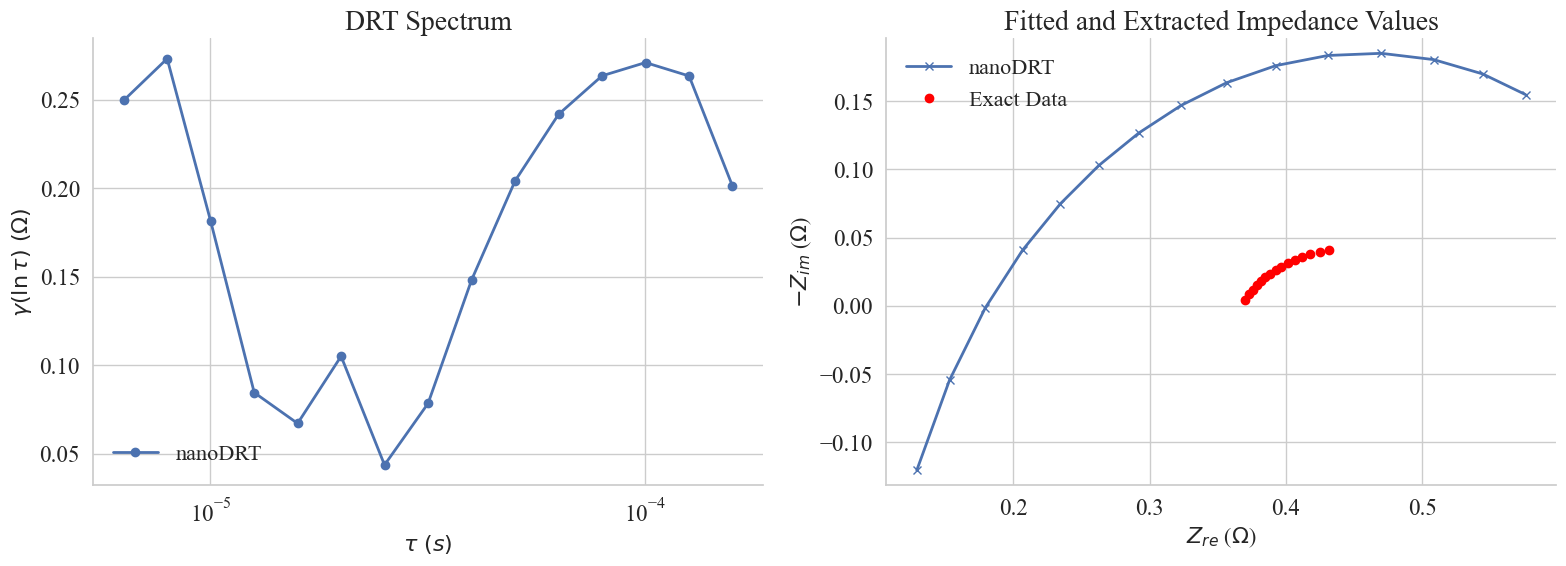

In [4]:
# nanoDRT

crop_indices = 15
df=df[:crop_indices]

f = df["f"].values
tau = 1./(2*jnp.pi*f)
#tau = 1./(f)
#tau = jnp.flip(jnp.logspace(np.log(tau.min()), np.log(tau.max()), 70))

Z_exact_re =  df["Z_re"].values
Z_exact_im =  df["Z_im"].values

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

# Create initial gamma guess
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7) # Guessing function for the DRT initially assume a guassian single ZARC Model 

# Create initial DRT object
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

# Build optimiser
solver_dict = {"init_lbd": 1e-4, "lbd_selection": None, 'maxiter': 1e2}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", integration_method="rbf", solver_dict = solver_dict, rbf_function="gaussian")
final_sim = optim.run()
print("Final residual is: ")
print(final_sim.value)

# Plot result
# plot = Plot(final_sim, measurement)
# plot.show()

# extract values for comparison

DRT_Re_Z_data, DRT_Im_Z_data = final_sim.simulate()

plot_fit_comparison(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=tau, gamma_list = final_sim.gamma, Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = "nanoDRT")

In [5]:
final_sim.R_inf
#final_sim.L_0
final_sim.A_matrices

Array([[[ 0.13912041,  0.13721094,  0.10205432,  0.07254125,
          0.04979539,  0.03321493,  0.02176017,  0.01403825,
          0.00898998,  0.00574408,  0.00364656,  0.00230948,
          0.00146169,  0.00092115,  0.00052227],
        [ 0.17220936,  0.17649184,  0.13778047,  0.10222582,
          0.07264625,  0.04975157,  0.03321492,  0.02170931,
          0.01402442,  0.00901189,  0.0057422 ,  0.00364533,
          0.00231063,  0.00145754,  0.00082684],
        [ 0.2028283 ,  0.21586502,  0.17724632,  0.13808974,
          0.10242437,  0.07263482,  0.0497879 ,  0.03316481,
          0.0217071 ,  0.0140705 ,  0.00901677,  0.00574534,
          0.00365037,  0.00230613,  0.00130937],
        [ 0.22853877,  0.25153046,  0.21665113,  0.17756456,
          0.13825942,  0.10234807,  0.07263633,  0.04967979,
          0.03313982,  0.02176195,  0.01406751,  0.00901495,
          0.00574888,  0.00364049,  0.00206983],
        [ 0.24847047,  0.28105773,  0.25232406,  0.21695293,
          0

# pyDRTtools

using Ed's tau edit
using Ed's tau fine removal
custom
     pcost       dcost       gap    pres   dres
 0: -2.3566e+00 -2.8981e+00  2e+01  4e+00  2e-01
 1: -2.1704e+00 -2.9432e+00  1e+00  8e-02  4e-03
 2: -2.3116e+00 -2.4763e+00  2e-01  6e-03  3e-04
 3: -2.3598e+00 -2.3848e+00  3e-02  2e-17  1e-16
 4: -2.3643e+00 -2.3664e+00  2e-03  6e-17  9e-17
 5: -2.3646e+00 -2.3648e+00  2e-04  6e-17  8e-17
 6: -2.3646e+00 -2.3647e+00  7e-05  6e-17  6e-17
 7: -2.3647e+00 -2.3647e+00  6e-05  6e-17  7e-17
 8: -2.3647e+00 -2.3647e+00  7e-06  6e-17  1e-16
 9: -2.3647e+00 -2.3647e+00  6e-07  6e-17  8e-17
10: -2.3647e+00 -2.3647e+00  1e-07  2e-18  8e-17
11: -2.3647e+00 -2.3647e+00  3e-09  1e-16  5e-17
12: -2.3647e+00 -2.3647e+00  3e-11  7e-17  7e-17
13: -2.3647e+00 -2.3647e+00  3e-13  6e-17  8e-17
14: -2.3647e+00 -2.3647e+00  3e-15  3e-17  1e-16
15: -2.3647e+00 -2.3647e+00  3e-17  6e-17  6e-17
Optimal solution found.
here is x
[3.72387285e-01 3.23435115e-16 3.89432411e-16 5.20165509e-16
 7.95133180e-16 1.

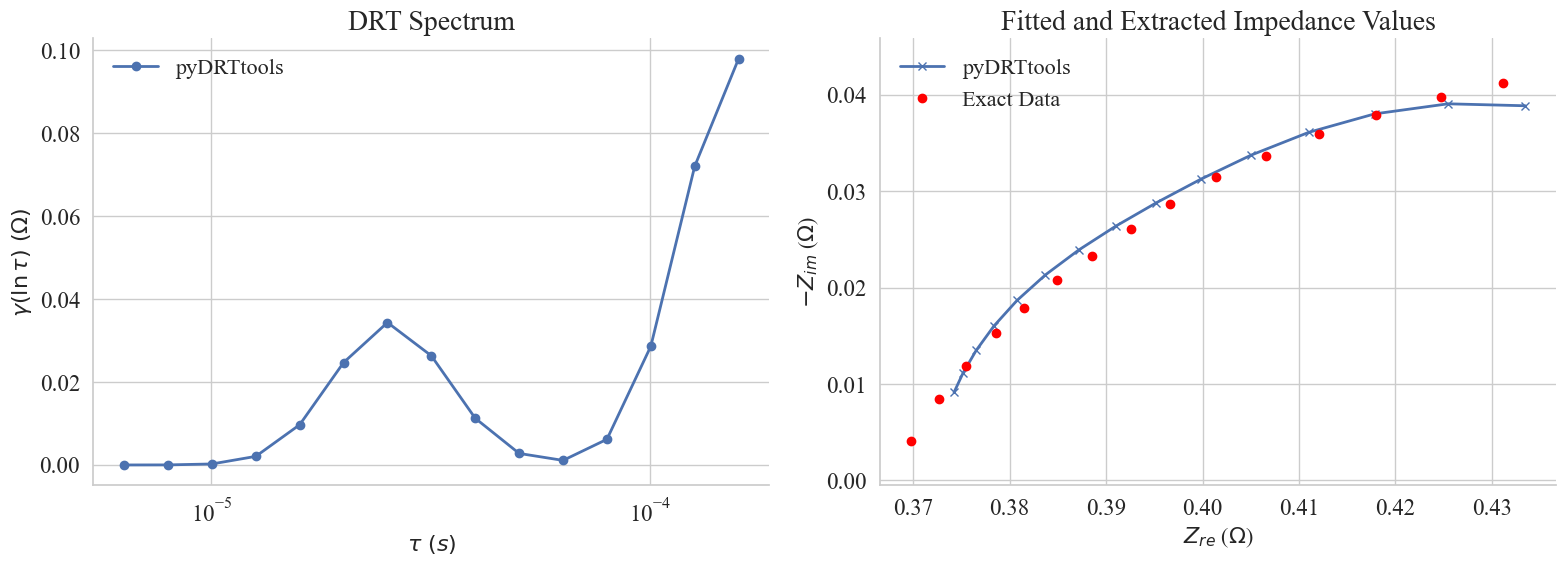

In [6]:
# Load measurement data into EIS_object
pyDRTtools_EIS_object = pyDRTtools.runs.EIS_object(df["f"].values, df["Z_re"].values, df["Z_im"].values)
# this includes tau definition of 
# # self.tau = 1/freq # we assume that the collocation points equal to 1/freq as default
# # self.tau_fine  = np.logspace(log10(self.tau.min())-0.5,log10(self.tau.max())+0.5,10*freq.shape[0])  

# print(pyDRTtools_EIS_object.Z_prime.shape[0])
# print(pyDRTtools_EIS_object.Z_double_prime.shape)
# print(pyDRTtools_EIS_object.freq.shape)
# print(pyDRTtools_EIS_object.Z_exp)

# ridge regression DRT
fitted_entry = pyDRTtools.runs.simple_run(entry=pyDRTtools_EIS_object, rbf_type = 'Gaussian', data_used = 'Combined Re-Im Data', induct_used = 0, der_used = '1st order', cv_type = 'custom', reg_param = 1E-9, shape_control = 'FWHM Coefficient', coeff = 0.333)

#extract fit
out_tau_vec = fitted_entry.out_tau_vec
x = fitted_entry.x
gamma = fitted_entry.gamma
DRT_Re_Z_data = fitted_entry.mu_Z_re
DRT_Im_Z_data = fitted_entry.mu_Z_im
Z_DRT = DRT_Re_Z_data + 1j*DRT_Im_Z_data
residuals_real = 100*fitted_entry.res_re/np.abs(Z_DRT)
residuals_imag = 100*fitted_entry.res_im/np.abs(Z_DRT)
series_R = fitted_entry.R
series_L = fitted_entry.L 

# something is up obviously. check on how i have been passing data to simple_run in python file. 
# looks like it might work fine with my experimental data? why not with ZARC data? 

print(len(df["f"].values))
print(len(x))
print(len(gamma), len(out_tau_vec))
print(len(DRT_Re_Z_data))

plot_fit_comparison(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=out_tau_vec, gamma_list = gamma, Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = "pyDRTtools")

In [8]:
# # for if comparing to analytical
#plot_fit_comparison(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=[out_tau_vec, tau_vec], gamma_list = [gamma, gamma_fct], Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = ["pyDRTtools", "analytical"])

In [ ]:
# define the range of log frequencies
log_freq_min = -4.
log_freq_max = 4.

# define the range of log timescales with tau=1/f as in the previous papers
log_tau_min = -4  
log_tau_max = 4   

# number of collocation points in log(freq) and log(tau)
N_freqs = 10*int(log_freq_max-log_freq_min)+1
N_taus = 10*int(log_tau_max-log_tau_min)+1

# freq and tau vectors
freq_vec = np.logspace(log_freq_min, log_freq_max, num = N_freqs, endpoint=True)
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec)

# the impedance and DRT of the single ZARC are calculated with the previous equations and the following parameters
R_inf = 10 # Ohm
R_ct = 50 # Ohm
phi = 0.8 # unitless
tau_0 = 1. # s

Z_exact = R_inf+R_ct/(1.0+(1j*2.*pi*freq_vec*tau_0)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec/tau_0))-cos((1.-phi)*pi))

# we will add white noise to the impedance computed analytically
rng = np.random.seed(12129)
sigma_n_exp = 0.5  
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

Z_exp_re = Z_exp.real
Z_exp_im = Z_exp.imag

df = pd.DataFrame({
    "f": freq_vec,
    "Z_re":Z_exp_re,
    "Z_im": Z_exp_im,
      })